#### Face Identity Classification
This example illustrates Model Inversion (MINV) attacks on a face identity classfier model. The classfier is trained on [Large-scale CelebA - Aligned&Cropped](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset. Please ensure the following structure in the data folder:

directory_structure:

```
data/
    ├── private/          # Private dataset
    │   ├── identity_1/
    │   │   ├── instance_1.jpg
    │   │   ├── instance_2.jpg
    │   │   └── ...
    │   ├── identity_2/
    │   │   ├── instance_1.jpg
    │   │   ├── instance_2.jpg
    │   │   └── ...
    │   └── ...
    └── public/           # Public dataset
        ├── identity_1/
        │   ├── instance_1.jpg
        │   ├── instance_2.jpg
        │   └── ...
        ├── identity_2/
        │   ├── instance_1.jpg
        │   ├── instance_2.jpg
        │   └── ...
        └── ...      
```


To prepare data for this example:

1. Download CelebA images "img_align_celeba.zip" from this [URL](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ) 
2. Download CelebA identities "identity_CelebA.txt" from this [URL](https://drive.google.com/drive/folders/0B7EVK8r0v71pOC0wOVZlQnFfaGs?resourcekey=0-pEjrQoTrlbjZJO2UL8K_WQ)
3. Unzip "img_align_celeba.zip" and place /img_align_celeba folder in examples/minv/celebA/data/
4. Place "identity_CelebA.txt" in examples/minv/celebA/data/
5. In the cell below select n classes to use, and n_private classes as private, n - n_private will be public.
6. Run the cell below

After running this, img_align_celebA folder can be removed if desired.

In [ ]:
# Description: This script partitions the CelebA dataset into public and private folders based on the identity of the person in the image.

import pandas as pd
import os
import shutil

# read img_align_celeba/identity_CelebA.txt
df = pd.read_csv('./data/identity_CelebA.txt', sep=' ', header=None)
df.columns = ['img', 'label']

# Parameters
n = 1000 # total number of classes to take, max 10177
n_private = 500 # number of classes to be private, max 10177 and <= n. The rest will be public

# Create folders
os.makedirs('./data', exist_ok=True)
os.makedirs('./data/private', exist_ok=True)
os.makedirs('./data/public', exist_ok=True)

# Copy images to folders based on label
for i in range(1,n+1):
    if i <= n_private:
        os.makedirs('./data/private/' + str(i), exist_ok=True)
        for img in df[df['label'] == i]['img']:
            shutil.copy('./data/img_align_celeba/' + img, './data/private/' + str(i) + '/' + img)
    else:
        os.makedirs('./data/public/' + str(i), exist_ok=True)
        for img in df[df['label'] == i]['img']:
            shutil.copy('./data/img_align_celeba/' + img, './data/public/' + str(i) + '/' + img)
    if i % 100 == 0:
        print(i / n * 100, 'percent copied')

# Train the target model

In [1]:
import os
import sys
import yaml

# Path to the dataset zip file
data_folder = "./data"


project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

In [2]:
from examples.minv.celebA.utils.celebA_data import get_celebA_dataloader

# Load the config.yaml file
with open('train_config.yaml', 'r') as file:
    train_config = yaml.safe_load(file)

# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), train_config["data"]["data_dir"])

#print(train_config)

train_loader, test_loader = get_celebA_dataloader(path, train_config)

num_classes = train_loader.dataset.dataset.get_classes()

Load data from ./data/celebA_private_data.pkl


Run this cell if you want to train the model, otherwise skip this and load it in cell below public loader

In [3]:
from examples.mia.celebA_HQ.utils.celeb_hq_model import ResNet18
from examples.mia.celebA_HQ.utils.celeb_hq_model import create_trained_model_and_metadata
# Get number of classes from the train_loader
num_classes = train_loader.dataset.dataset.get_classes()
print(num_classes)

import torch
# Create the model
model = ResNet18(num_classes=num_classes)

device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Load the model
train_acc, train_loss, test_acc, test_loss = create_trained_model_and_metadata(model,train_loader,test_loader, train_config)

500


Training Progress: 100%|██████████| 30/30 [02:24<00:00,  4.80s/it]


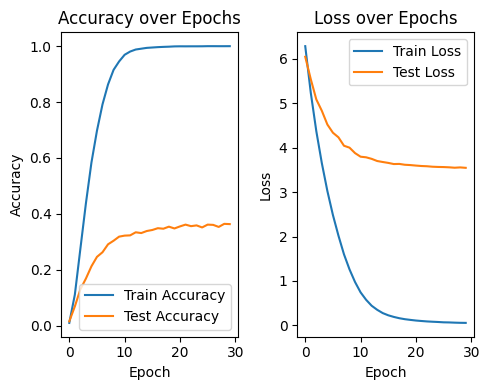

In [5]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [3]:
# Public loader
from examples.minv.celebA.utils.celebA_data import get_celebA_publicloader

pub_loader = get_celebA_publicloader(path, train_config)


Load data from ./data/celebA_public_data.pkl


In [4]:
import torch
from torch.nn import functional as F
import numpy as np
from examples.mia.celebA_HQ.utils.celeb_hq_model import ResNet18

# We have model_metadata.pkl and target_model.pkl. Load metadata and target model
# Load the model
num_classes = train_loader.dataset.dataset.get_classes()
model = ResNet18(num_classes=num_classes)
model.load_state_dict(torch.load('./target/target_model.pkl'))
model.eval()


ResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

Remove dis.pth and gen.pth if you want LeakPro to enter training loop. Number of iterations set to n_iter = 10 in this example.

Currently, result class is not setup.

In [ ]:
from leakpro import LeakPro
from examples.minv.celebA.celebA_plgmi_handler import CelebA_InputHandler
config_path = "audit.yaml"


# Initialize the LeakPro object
leakpro = LeakPro(CelebA_InputHandler, config_path)

# Run the audit
results = leakpro.run_audit(return_results=True)


2025-02-21 13:36:54,268 INFO     Target model blueprint created from ResNet18 in ../../mia/celebA_HQ/utils/celeb_hq_model.py.
INFO:leakpro:Target model blueprint created from ResNet18 in ../../mia/celebA_HQ/utils/celeb_hq_model.py.
2025-02-21 13:36:54,270 INFO     Loaded target model metadata from ./target/model_metadata.pkl
INFO:leakpro:Loaded target model metadata from ./target/model_metadata.pkl


Configurations: {'audit': {'random_seed': 1234, 'attack_list': {'plgmi': {'n_dis': 2, 'n_iter': 10, 'batch_size': 32, 'gen_lr': 0.0005, 'dis_lr': 0.0002, 'gen_beta1': 0.0, 'gen_beta2': 0.9, 'dis_beta1': 0.0, 'dis_beta2': 0.9, 'dim_z': 128, 'alpha': 0.2, 'log_interval': 10, 'num_classes': 500, 'generator': {'module_path': './utils/generator.py', 'model_class': 'ResNetGenerator', 'checkpoint_path': 'generator.pth', 'init_params': {'dim_z': 128, 'num_classes': 500, 'bottom_width': 4}}, 'discriminator': {'module_path': './utils/discriminator.py', 'model_class': 'SNResNetProjectionDiscriminator', 'checkpoint_path': 'discriminator.pth', 'init_params': {'num_classes': 500}}}}, 'reconstruction': {'num_class_samples': 1, 'num_audited_classes': 500, 'metrics': {'accuracy': None, 'fid': None}}, 'output_dir': './leakpro_output', 'attack_type': 'minv', 'modality': 'image'}, 'target': {'module_path': '../../mia/celebA_HQ/utils/celeb_hq_model.py', 'model_class': 'ResNet18', 'target_folder': './target

2025-02-21 13:36:54,511 INFO     Loaded target model from ./target
INFO:leakpro:Loaded target model from ./target
2025-02-21 13:36:55,293 INFO     Loaded population dataset from ./data/celebA_private_data.pkl
INFO:leakpro:Loaded population dataset from ./data/celebA_private_data.pkl
2025-02-21 13:36:55,294 INFO     Loaded population dataset from ./data/celebA_private_data.pkl
INFO:leakpro:Loaded population dataset from ./data/celebA_private_data.pkl
2025-02-21 13:36:55,630 INFO     MINV attack factory loaded.
INFO:leakpro:MINV attack factory loaded.
2025-02-21 13:36:55,632 INFO     Configuring PLG-MI attack
INFO:leakpro:Configuring PLG-MI attack
2025-02-21 13:36:55,848 INFO     Added attack: plgmi
INFO:leakpro:Added attack: plgmi
2025-02-21 13:36:55,849 INFO     Preparing attack: plgmi
INFO:leakpro:Preparing attack: plgmi
2025-02-21 13:36:55,850 INFO     Preparing attack
INFO:leakpro:Preparing attack
2025-02-21 13:36:55,852 INFO     Setting up generator configurations
INFO:leakpro:Sett

iteration: 00000/00010, loss gen: -0.312213, loss dis 3.683944, inv loss 5.141943, target acc 0.000000, time 13:37:28


2025-02-21 13:37:44,288 INFO     Running attack: plgmi
INFO:leakpro:Running attack: plgmi
2025-02-21 13:37:44,289 INFO     Running the PLG-MI attack
INFO:leakpro:Running the PLG-MI attack
2025-02-21 13:37:44,290 INFO     Configuring ImageMetrics
INFO:leakpro:Configuring ImageMetrics
2025-02-21 13:37:44,291 INFO     {'num_class_samples': 1, 'num_audited_classes': 500, 'metrics': {'accuracy': None, 'fid': None}}
INFO:leakpro:{'num_class_samples': 1, 'num_audited_classes': 500, 'metrics': {'accuracy': None, 'fid': None}}
2025-02-21 13:37:45,096 INFO     Loaded private data from ./data/celebA_private_data.pkl
INFO:leakpro:Loaded private data from ./data/celebA_private_data.pkl
2025-02-21 13:37:45,098 INFO     Computing accuracy for generated samples.
INFO:leakpro:Computing accuracy for generated samples.
2025-02-21 13:37:49,767 INFO     Accuracy: 0.0020000000949949026
INFO:leakpro:Accuracy: 0.0020000000949949026
2025-02-21 13:37:49,768 INFO     Computing FID between real and generated samp

AttributeError: 'dict' object has no attribute 'attack_name'

Generate some sample images

tensor([254, 144, 204, 244], device='cuda:0')


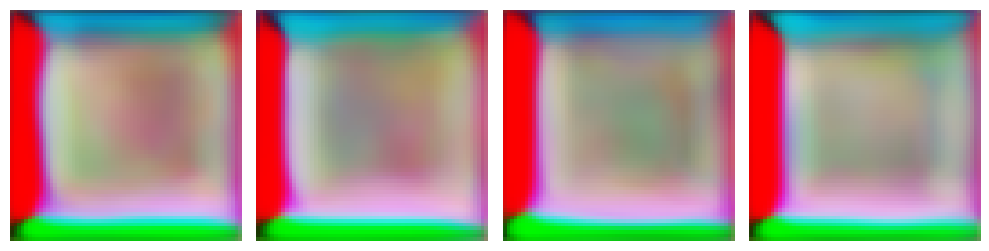

In [ ]:
from examples.minv.celebA.utils.generator import ResNetGenerator
import torch
import matplotlib.pyplot as plt
import numpy as np

"""Generate example images using the trained generator"""

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Make sure that this matches the generator's parameters selected in audit.yaml
dim_z = 128
# Load generator and discriminator
gen = ResNetGenerator(num_classes=num_classes, dim_z=dim_z).to(device)
gen.load_state_dict(torch.load('gen.pth'))

# Generate images
gen.eval()

n_images = 4
z = torch.empty(n_images, dim_z, dtype=torch.float32, device=device).normal_()
y = torch.randint(0, num_classes, (n_images,)).to(device) # random labels
#y = torch.tensor([0, 1, 2, 3]).to(device) # fixed labels
print(y) 

with torch.no_grad():
    fake = gen(z, y)

# Normalize the generated images to the range [0, 1]
fake = (fake - fake.min()) / (fake.max() - fake.min())

# Plot the generated images
plt.figure(figsize=(10, 5))
for i in range(n_images):
    plt.subplot(1, n_images, i + 1)
    plt.imshow(np.transpose(fake[i].cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
plt.tight_layout()
plt.show()

# Printed tensor corresponds to the reconstructed identity in private dataset